# Q learning
- Sarsaの場合は、更新時に次の行動a(t+1)を求め、更新に使用していた。
- Q学習は状態st+1のうち、もっとも大きいものを更新に使用する。
- 更新が行動の決定方法に依存しないため、ランダム性が更新式に入らない分、Sarsaよりも学習の収束が早い。
- 更新式が変わるだけである。
- 行動関数の値に0.1をかけるのは小さくすることではじめの方での実験での失敗を減らすため。

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

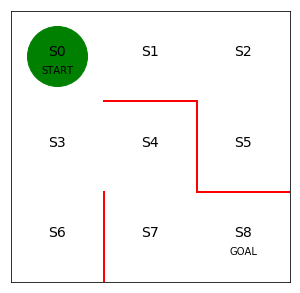

In [44]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [45]:
# 初期の方策を決定するパラメータtheta_0を設定
# 方策　エージェントがどのように行動するかを決めたルール
# pi_theta(s, a)
# 状態sの時に行動aを採用する確率はパラメータthetaで決まる方策piに従う。

# 表形式表現　行が状態、列が行動aを示し、値はその行動を採用する確率
# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
# columns ========> [up    . right , down  , left  ]   # rows
theta_0 = np.array([[np.nan, 1     , 1     , np.nan],  # s0
                    [np.nan, 1     , np.nan, 1     ],  # s1
                    [np.nan, np.nan, 1     , 1     ],  # s2
                    [1     , 1     , 1     , np.nan],  # s3
                    [np.nan, np.nan, 1     , 1     ],  # s4
                    [1     , np.nan, np.nan, np.nan],  # s5
                    [1     , np.nan, np.nan, np.nan],  # s6
                    [1     , 1     , np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [55]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義
def simple_convert_into_pi_from_theta(theta):
    
    i, j = theta.shape
    pi = np.zeros((i, j))
    for idx in range(i):
        pi[idx, :] = theta[idx, :] / np.nansum(theta[idx, :])
        
    pi = np.nan_to_num(pi)
    return pi

In [56]:
# 方策を定義
pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [57]:
# 初期の行動価値関数Qを設定
i, j = theta_0.shape
Q = np.random.rand(i, j) * theta_0 * 0.1
Q

array([[       nan, 0.0987029 , 0.0868154 ,        nan],
       [       nan, 0.03985942,        nan, 0.04348059],
       [       nan,        nan, 0.09251362, 0.0096399 ],
       [0.09142557, 0.08228379, 0.04924956,        nan],
       [       nan,        nan, 0.00472318, 0.06719231],
       [0.03189383,        nan,        nan,        nan],
       [0.07883168,        nan,        nan,        nan],
       [0.05326319, 0.0994967 ,        nan,        nan]])

In [58]:
# ε-greedy法を実装

def get_action(s, Q, epsilon, pi_0):
    direction = ["UP", "RIGHT", "DOWN", "LEFT"]
    # epsilon-greedy methods
    if np.random.rand() < epsilon:
        next_action = np.random.choice(direction, p=pi_0[s, :])
    else:
        next_action = direction[np.nanargmax(Q[s, :])]
        
    if next_action == "UP":
        action = 0
    elif next_action == "RIGHT":
        action = 1
    elif next_action == "DOWN":
        action = 2
    elif next_action == "LEFT":
        action = 3
    
    return action

def get_s_next(s, a):
    
    direction = ["UP", "RIGHT", "DOWN", "LEFT"]
    next_action = direction[a]
    
    if next_action == "UP":
        s_next = s - 3
    elif next_action == "RIGHT":
        s_next = s + 1
    elif next_action == "DOWN":
        s_next = s + 3
    elif next_action == "LEFT":
        s_next = s - 1
        
    return s_next

In [59]:
# Q学習による行動価値関数Qの更新

def Q_learning(s, a, r, s_next, Q, eta, gamma):
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
    
    return Q

In [60]:
# Q学習で迷路を解く関数の定義、状態と行動の履歴および更新したQを出力


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    
    s = 0
    a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[0, np.nan]]
    
    while True:
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s, a)
        s_a_history.append([s_next, np.nan])
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            
        # print("State: {}, Action: {}".format(s_next, a_next))
            
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
        
    return s_a_history, Q

In [61]:
# Q学習で迷路を解く

eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []
V.append(np.nanmax(Q, axis=1))

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き、移動した履歴と更新したQを求める
    s_a_history, Q = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値関数の変化を出力
    v = new_v
    V.append(v)  # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break

エピソード:1
0.1867225303381354
迷路を解くのにかかったステップ数は84です
エピソード:2
0.10480585534825887
迷路を解くのにかかったステップ数は60です
エピソード:3
0.29779683195105805
迷路を解くのにかかったステップ数は814です
エピソード:4
0.09436196333708721
迷路を解くのにかかったステップ数は14です
エピソード:5
0.09281534491377058
迷路を解くのにかかったステップ数は8です
エピソード:6
0.09102140603742118
迷路を解くのにかかったステップ数は4です
エピソード:7
0.09008911807551262
迷路を解くのにかかったステップ数は4です
エピソード:8
0.08911970653721432
迷路を解くのにかかったステップ数は4です
エピソード:9
0.08810001944270335
迷路を解くのにかかったステップ数は4です
エピソード:10
0.0870190200299133
迷路を解くのにかかったステップ数は4です
エピソード:11
0.08586797150932284
迷路を解くのにかかったステップ数は4です
エピソード:12
0.08464047732404019
迷路を解くのにかかったステップ数は4です
エピソード:13
0.08333241648210515
迷路を解くのにかかったステップ数は4です
エピソード:14
0.08194180542030247
迷路を解くのにかかったステップ数は4です
エピソード:15
0.08046861117969245
迷路を解くのにかかったステップ数は4です
エピソード:16
0.07891453519373871
迷路を解くのにかかったステップ数は4です
エピソード:17
0.0772827825158467
迷路を解くのにかかったステップ数は4です
エピソード:18
0.0755778276792007
迷路を解くのにかかったステップ数は4です
エピソード:19
0.07380518544805377
迷路を解くのにかかったステップ数は4です
エピソード:20
0.07197119236767456
迷路を解くのにかかったステップ数は4です
エピソード:21

In [62]:
# 状態価値の変化を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5], [2.5], marker="s",
                    color=cm.jet(V[i][0]), markersize=85)  # S0
    line, = ax.plot([1.5], [2.5], marker="s",
                    color=cm.jet(V[i][1]), markersize=85)  # S1
    line, = ax.plot([2.5], [2.5], marker="s",
                    color=cm.jet(V[i][2]), markersize=85)  # S2
    line, = ax.plot([0.5], [1.5], marker="s",
                    color=cm.jet(V[i][3]), markersize=85)  # S3
    line, = ax.plot([1.5], [1.5], marker="s",
                    color=cm.jet(V[i][4]), markersize=85)  # S4
    line, = ax.plot([2.5], [1.5], marker="s",
                    color=cm.jet(V[i][5]), markersize=85)  # S5
    line, = ax.plot([0.5], [0.5], marker="s",
                    color=cm.jet(V[i][6]), markersize=85)  # S6
    line, = ax.plot([1.5], [0.5], marker="s",
                    color=cm.jet(V[i][7]), markersize=85)  # S7
    line, = ax.plot([2.5], [0.5], marker="s",
                    color=cm.jet(1.0), markersize=85)      # S8
    
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())

# Sarsa との違い
- 更新式において
    - 次の行動から得られる価値と今の状態での価値の差を用いるのがsarsa
    - 次に取りうる値のうち最大の価値を持つものと持たないもので差を用いるのがQ学習
    - Q学習の方が、次の行動に依存した更新をしないので早く収束する